In [956]:
import sys
print(sys.executable)
print(sys.path)

/Users/chenxi/my_env_3.9/bin/python
['/Users/chenxi/developer/root/root-6.32.00-install/lib', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/chenxi/my_env_3.9/lib/python3.9/site-packages']


In [957]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle, Circle, Wedge, Polygon
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf
from scipy.optimize import minimize
from numpy.random import default_rng
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import Point, Polygon as ShapelyPolygon
from shapely.geometry import MultiPoint
from shapely.prepared import prep
import re
rng = default_rng()

In [958]:
class DetectorParams:
    """All detector and electronics parameters in one place"""
    
    # Gas properties / drift
    D_T = 175.0              # μm/√cm - transverse diffusion coefficient
    D_L = 230.0              # μm/√cm - longitudinal diffusion coefficient  
    v_drift = 8.0e-3          # cm/ns = 8.0e-3 cm/ns - drift velocity
    TPC_length = 105.5       # cm - TPC drift length (cathode to readout)
    
    # Avalanche intrinsic spreads (GEM/Micromegas)
    sigma_aval_r = 1.5      # mm - transverse spread from avalanche
    sigma_aval_t = sigma_aval_r/v_drift / 10     # ns - temporal spread from avalanche
    
    # Gain parameters
    gain_mean = 1400         # Average avalanche gain
    polya_theta = 0.8        # Polya parameter
    
    # Electronics shaping (CR-RC with n=1)
    tau_shaper = 50.0       # ns - shaping time constant
    #sampa_shaping_lead = 32.0  # ns - SAMPA shaping time lead
    #sampa_shaping_tail = 48.0  # ns - SAMPA shaping time tail
    
    # Digitization
    adc_dt = 53.326184       # ns - TPC ADC clock period
    window_ns = 22653.0      # ns - total readout window (425 samples)
    adc_bits = 10  
    adc_conversion = 0.1     # mV per electron (after gain)
    adc_noise = 5.0          # ADC counts RMS noise
    adc_threshold = 0     # ADC threshold
    
    # Pad geometry
    pad_geometry = 'rectangular'  # 'rectangular' or 'rphi'
    
    # For rectangular pads
    pad_width_mm = 4.0       # mm - pad width in x
    pad_height_mm = 4.0      # mm - pad height in y
    
    # For r-φ pads  
    pad_r_mm = 4.0           # mm - pad radial size
    pad_phi_mrad = 10.0      # mrad - pad angular size (at reference radius)
    r_reference = 100.0      # mm - reference radius for phi calculation
    
    # Coverage
    n_sigma_pad = 3 

In [ ]:
NSectors = 12
min_radii_module = [314.9836110818037, 416.59202613529567, 589.1096495597712]
max_radii_module = [399.85222874031024, 569.695373910603, 753.6667758418596]
delta_R_module = [5.630547309825637, 5.6891770257002054, 10.206889851687158, 10.970475085472556]
left_phi_module = [ 1.814070180963218, 1.8196038006425466, 1.8231920135309803]
right_phi_module = [ 1.3233741362052793, 1.3190806892129499, 1.3183480511410641]
tpc_x_sizes = [[-101, 101],[-151, 151],[-201, 201]]
tpc_y_sizes = [[300, 405],[395, 575],[560, 760]]
# Global derived values
P = DetectorParams()
NT = int(P.window_ns // P.adc_dt)
BIN_EDGES = np.arange(NT + 1) * P.adc_dt  
BIN_CENTERS = 0.5 * (BIN_EDGES[:-1] + BIN_EDGES[1:])

In [960]:
'''
def to_initial_sector(track):
    """
    track: dict with 'x','y','z' lists in same units (here mm for x,y, cm for z)
    returns: dict of rotated coords + which sector and side it came from
    """
    x0_raw = np.asarray(track['x'])
    y0_raw = np.asarray(track['y'])
    z0_raw = np.asarray(track['z'])

    # drop anything outside your largest radius  
    R_raw = np.sqrt(x0_raw**2 + y0_raw**2)
    mask  = (R_raw < max_radii_module[2])  # note: these radii are in mm
    x0 = x0_raw[mask];  y0 = y0_raw[mask];  z0 = z0_raw[mask]
    R  = R_raw[mask]

    # compute original φ
    phi = np.arctan2(y0, x0)

    # which end-cap?
    side = 1 if np.all(z0 < 0) else 0

    # what wedge index?
    pie    = np.pi / NSectors
    sector = np.abs((phi - 2*np.pi/6) // pie).astype(int)

    # shift φ so this sector lands in [−π/NSectors, +π/NSectors]
    phi_shift = np.pi - (sector + 3)*np.pi/6
    phi0 = phi - phi_shift

    # rotate back to Cartesian
    x_new = R * np.cos(phi0)
    y_new = R * np.sin(phi0)

    return {
        'x':      x_new,
        'y':      y_new,
        'z':      z0,
        'sector': sector,
        'side':   side
    }
    '''

'\ndef to_initial_sector(track):\n    """\n    track: dict with \'x\',\'y\',\'z\' lists in same units (here mm for x,y, cm for z)\n    returns: dict of rotated coords + which sector and side it came from\n    """\n    x0_raw = np.asarray(track[\'x\'])\n    y0_raw = np.asarray(track[\'y\'])\n    z0_raw = np.asarray(track[\'z\'])\n\n    # drop anything outside your largest radius  \n    R_raw = np.sqrt(x0_raw**2 + y0_raw**2)\n    mask  = (R_raw < max_radii_module[2])  # note: these radii are in mm\n    x0 = x0_raw[mask];  y0 = y0_raw[mask];  z0 = z0_raw[mask]\n    R  = R_raw[mask]\n\n    # compute original φ\n    phi = np.arctan2(y0, x0)\n\n    # which end-cap?\n    side = 1 if np.all(z0 < 0) else 0\n\n    # what wedge index?\n    pie    = np.pi / NSectors\n    sector = np.abs((phi - 2*np.pi/6) // pie).astype(int)\n\n    # shift φ so this sector lands in [−π/NSectors, +π/NSectors]\n    phi_shift = np.pi - (sector + 3)*np.pi/6\n    phi0 = phi - phi_shift\n\n    # rotate back to Cartesian\

In [961]:
'''
def to_initial_sector(track):
    """
    Rotate a list of (x,y,z) points *in mm* into the sector‐0 wedge.
    Returns dict of x,y,z (all mm), plus per‐point sector and side arrays.
    """
    x0 = np.asarray(track['x'], dtype=float)
    y0 = np.asarray(track['y'], dtype=float)
    z0 = np.asarray(track['z'], dtype=float)
    R  = np.hypot(x0, y0)

    OUTER = max_radii_module[2]       # mm, from your constants
    mask = R <= (OUTER + 1e-6)        # a hair of slack
    if not np.any(mask):
        raise RuntimeError(f"to_initial_sector: all points dropped!  R={R}, limit={OUTER}")

    x0 = x0[mask];   y0 = y0[mask];   z0 = z0[mask];   R = R[mask]
    phi = np.arctan2(y0, x0)

    # side = 1 if below z=0, else 0
    side = (z0 < 0).astype(int)

    # cut into NSectors slices of width π/NSectors
    pie    = np.pi/NSectors
    raw    = phi - 2*np.pi/6
    sector = np.abs((raw // pie).astype(int))

    # shift each phi back into the [–π/NSectors … +π/NSectors] window
    phi0   = phi - (np.pi - (sector + 2)*np.pi/6)
    x_new  = R * np.cos(phi0)
    y_new  = R * np.sin(phi0)

    return {
      'x':      x_new,
      'y':      y_new,
      'z':      z0,
      'sector': sector,
      'side':   side
    }
    '''


'\ndef to_initial_sector(track):\n    """\n    Rotate a list of (x,y,z) points *in mm* into the sector‐0 wedge.\n    Returns dict of x,y,z (all mm), plus per‐point sector and side arrays.\n    """\n    x0 = np.asarray(track[\'x\'], dtype=float)\n    y0 = np.asarray(track[\'y\'], dtype=float)\n    z0 = np.asarray(track[\'z\'], dtype=float)\n    R  = np.hypot(x0, y0)\n\n    OUTER = max_radii_module[2]       # mm, from your constants\n    mask = R <= (OUTER + 1e-6)        # a hair of slack\n    if not np.any(mask):\n        raise RuntimeError(f"to_initial_sector: all points dropped!  R={R}, limit={OUTER}")\n\n    x0 = x0[mask];   y0 = y0[mask];   z0 = z0[mask];   R = R[mask]\n    phi = np.arctan2(y0, x0)\n\n    # side = 1 if below z=0, else 0\n    side = (z0 < 0).astype(int)\n\n    # cut into NSectors slices of width π/NSectors\n    pie    = np.pi/NSectors\n    raw    = phi - 2*np.pi/6\n    sector = np.abs((raw // pie).astype(int))\n\n    # shift each phi back into the [–π/NSectors … +π/N

In [962]:
def rotate_point_to_sector(x0, y0, z0):
    """
    Rotate a single point (x0,y0,z0) in mm into the sector-0 wedge.
    Returns: x_rot, y_rot, z0, sector, side
    """
    # 1) radius and phi
    R   = np.hypot(x0, y0)
    if R > max_radii_module[2] + 1e-6:
        raise ValueError(f"Point R={R:.1f} mm outside outer radius")
    phi = np.arctan2(y0, x0)

    # 2) which side of the TPC (z<0 => side=1)
    side = int(z0 < 0)

    # 3) determine the sector index
    pie    = np.pi / NSectors                    # wedge half-width
    raw    = phi - 2*np.pi/6                     # align your "2π/6" offset
    sector = int(abs((raw // pie)))              # floor division then abs

    # 4) compute the shift to bring that sector back to “sector 0”
    phi_shift = np.pi - (sector + 2) * np.pi/6

    # 5) rotate the point
    phi0   = phi - phi_shift
    x_rot  = R * np.cos(phi0)
    y_rot  = R * np.sin(phi0)

    return x_rot, y_rot, z0, sector, side

In [963]:
'''
def build_serf_zigzag_in_sector(x0_cm, y0_cm, z0_cm, df_centroids, return_components=False):
    """
    Rotate (x0,y0) into sector 0 wedge, then call your existing SERF routine.
    """
    # convert to mm for the rotation routine
    track = {'x':[x0_cm*10], 'y':[y0_cm*10], 'z':[z0_cm]}
    ti = to_initial_sector(track)

    # now get the first (and only) rotated point
    x0s = ti['x'][0] / 10.0   # back to cm
    y0s = ti['y'][0] / 10.0   # back to cm

    # call your existing SERF builder
    serf, params, components = build_serf_zigzag(x0s, y0s, z0_cm, df_centroids, return_components=True)

    # stash the sector & side in params if you want to display them
    params['sector'] = int(ti['sector'][0])
    params['side']   = int(ti['side'][0])

    if return_components:
        return serf, params, components
    else:
        return serf, params
        '''

'\ndef build_serf_zigzag_in_sector(x0_cm, y0_cm, z0_cm, df_centroids, return_components=False):\n    """\n    Rotate (x0,y0) into sector 0 wedge, then call your existing SERF routine.\n    """\n    # convert to mm for the rotation routine\n    track = {\'x\':[x0_cm*10], \'y\':[y0_cm*10], \'z\':[z0_cm]}\n    ti = to_initial_sector(track)\n\n    # now get the first (and only) rotated point\n    x0s = ti[\'x\'][0] / 10.0   # back to cm\n    y0s = ti[\'y\'][0] / 10.0   # back to cm\n\n    # call your existing SERF builder\n    serf, params, components = build_serf_zigzag(x0s, y0s, z0_cm, df_centroids, return_components=True)\n\n    # stash the sector & side in params if you want to display them\n    params[\'sector\'] = int(ti[\'sector\'][0])\n    params[\'side\']   = int(ti[\'side\'][0])\n\n    if return_components:\n        return serf, params, components\n    else:\n        return serf, params\n        '

In [964]:
def build_serf_zigzag(x0_cm, y0_cm, z0_cm, df_centroids, return_components=False):
    """
    Build Single Electron Response Function for zigzag pads
    
    Args:
        x0_cm, y0_cm, z0_cm: Initial electron position in cm
        df_centroids: List of DataFrames for each module
        return_components: If True, return intermediate arrays
    """
    # Convert to mm
    x0_mm = x0_cm * 10
    y0_mm = y0_cm * 10
    z0_mm = z0_cm * 10
    
    # Calculate cloud parameters
    cloud_params = calculate_cloud_parameters(z0_cm)
    
    # Get pad charge fractions
    pad_fractions, module = get_zigzag_pad_fractions(
        x0_mm, y0_mm, z0_mm, cloud_params['sigma_total_r'], df_centroids
    )
    
    # Time distribution (before shaping)
    time_fractions = np.zeros(NT)
    for k in range(NT):
        time_fractions[k] = gaussian_integral_1d(
            BIN_EDGES[k], BIN_EDGES[k+1], 
            cloud_params['t_drift_ns'], 
            cloud_params['sigma_total_t']
        )
    
    # Apply shaping
    shaped_response = np.convolve(time_fractions, SHAPER_KERNEL, mode='full')[:NT]
    
    # Normalize
    if np.sum(shaped_response) > 0:
        shaped_response = shaped_response / np.sum(shaped_response)
    
    # Build SERF
    serf = {}
    for pad_id, frac in pad_fractions.items():
        serf[(module, pad_id)] = frac * shaped_response
    
    # Prepare return values
    params = {
        **cloud_params,
        'x0_mm': x0_mm,
        'y0_mm': y0_mm,
        'module': module,
        'n_pads': len(pad_fractions)
    }
    
    if return_components:
        components = {
            'pad_fractions': pad_fractions,
            'time_fractions': time_fractions,
            'shaped_response': shaped_response
        }
        return serf, params, components
    else:
        return serf, params

In [965]:
def build_serf_zigzag_in_sector(x0_cm, y0_cm, z0_cm, df_centroids, return_components=False):
    """
    Rotate (x0,y0,z0) into sector 0 and then call your existing zigzag SERF.
    x0_cm,y0_cm in cm, z0_cm in cm.
    """
    # prepare “track” in mm
    #track = {
    #  'x': [x0_cm*10.0],
    #  'y': [y0_cm*10.0],
    #  'z': [z0_cm*10.0]
    #}
    x0_mm= x0_cm * 10.0
    y0_mm= y0_cm * 10.0
    z0_mm = z0_cm * 10.0  # convert to mm for rotation
    ti = rotate_point_to_sector(x0_mm, y0_mm, z0_mm)
    # unpack the one (and only) rotated point, back to cm
    x0s = ti[0] / 10.0
    y0s = ti[0] / 10.0

    # now call your old zigzag SERF
    serf, params, comps = build_serf_zigzag(x0s, y0s, z0_cm, df_centroids, return_components=True)

    # tag on sector/side if you want to plot it
    params['sector'] = int(ti[3])
    params['side']   = int(ti[4])

    if return_components:
        return serf, params, comps
    else:
        return serf, params

In [967]:
maps = [ 
    '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R1-RevA.sch',
    '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R2-RevA-Pads.sch',
    '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R3-RevA.sch',
]

In [968]:
def get_pad_coordinates(root):
    '''Reading all the vertices of the pads from the xml ElementTree '''
    all_elements = [elem.tag for elem in root.iter()]
    all_attributes = [elem.attrib for elem in root.iter()]
    i = 0
    f_vertex = False
    f_wire = False
    all_vertices = []
    vertex_array = []
    pad_names = []
    pad_name = ''
    
    for ele in all_elements:
        if f_vertex:
            if ele == 'vertex':
                vertex_array.append(all_attributes[i])
            else:
                pad_names.append(pad_name)
                all_vertices.append(vertex_array)
                f_vertex = False
                f_wire = False
        if f_wire:
            if ele == 'wire' and all_attributes[i]['layer'] == '16':
                vertex_array.append({'x': all_attributes[i]['x1'], 'y': all_attributes[i]['y1']})
                vertex_array.append({'x': all_attributes[i]['x2'], 'y': all_attributes[i]['y2']})
            elif ele == 'signal':
                pad_names.append(pad_name)
                all_vertices.append(vertex_array)
                f_vertex = False
                f_wire = False
        
        if ele == 'signal':
            pad_name = all_attributes[i]['name']
        
        if ele == 'polygon':
            if all_attributes[i]['layer'] == '16':
                f_vertex = True
                vertex_array = []
        
        if re.match(r"DC*", pad_name):
            if ele == 'signal':
                f_wire = True
                vertex_array = []
        
        i += 1
    
    return all_vertices, pad_names

In [969]:
def process_pad_vertices(all_vertices, all_PadNames):
    """Process pad vertices and create DataFrame with pad properties"""
    pads_xy = {
        'PadName': [],
        'PadX': [],
        'PadY': [],
        'PadR': [],
        'PadPhi': [],
        'PadPath': [],
        'PadNumber': []
    }
    
    iter = 0
    for vx_array, padName in zip(all_vertices, all_PadNames):
        iter += 1
        
        # Extract vertices
        x_vx = []
        y_vx = []
        r_vx = []
        phi_vx = []
        xy_vx = []
        
        for vx in vx_array:
            x_vx.append(float(vx['x']))
            y_vx.append(float(vx['y']))
            r = np.sqrt(float(vx['y'])**2 + float(vx['x'])**2)
            phi = np.arctan2(float(vx['y']), float(vx['x']))
            r_vx.append(r)
            phi_vx.append(phi)
            xy_vx.append([float(vx['x']), float(vx['y'])])
        
        # Calculate centroid
        phi_vx.sort()
        phi_mins = phi_vx[:18] if len(phi_vx) >= 18 else phi_vx[:len(phi_vx)//2]
        phi_maxs = phi_vx[-18:] if len(phi_vx) >= 18 else phi_vx[len(phi_vx)//2:]
        new_phi_min = sum(phi_mins) / len(phi_mins) if phi_mins else phi_vx[0]
        new_phi_max = sum(phi_maxs) / len(phi_maxs) if phi_maxs else phi_vx[-1]
        
        # Make Path
        xy_vx.append(xy_vx[0])  # Close the polygon
        codes = [Path.MOVETO] + [Path.LINETO] * (len(xy_vx) - 2) + [Path.CLOSEPOLY]
        path = Path(xy_vx, codes)
        
        # Calculate center
        r_vx.sort()
        if len(r_vx) > 4:
            r_vx = r_vx[2:-2]
        c_r = sum(r_vx) / len(r_vx) if r_vx else 0
        c_phi = (new_phi_max + new_phi_min) / 2
        c_x = c_r * np.cos(c_phi)
        c_y = c_r * np.sin(c_phi)
        
        pads_xy['PadName'].append(padName)
        pads_xy['PadX'].append(c_x)
        pads_xy['PadY'].append(c_y)
        pads_xy['PadR'].append(c_r)
        pads_xy['PadPhi'].append(c_phi)
        pads_xy['PadPath'].append(path)
        pads_xy['PadNumber'].append(iter)
    
    df = pd.DataFrame(data=pads_xy)
    
    # Sort by radius and phi
    df['PadR_group'] = df['PadR'].round(3)
    df_sorted = df.sort_values(by=['PadR_group', 'PadPhi'], ascending=[True, False])
    df_sorted = df_sorted.reset_index(drop=True)
    df_sorted['PadNumber'] = df_sorted.index + 1
    
    return df_sorted

In [970]:
def load_pad_planes(brd_maps):
    """Load all three pad plane modules"""
    df_centroids = []
    
    for module_idx, brd_map in enumerate(brd_maps):
        tree = ET.parse(brd_map)
        root = tree.getroot()

        # after: give it the Element
        all_vertices, all_PadNames = get_pad_coordinates(tree)
        
        # Process into DataFrame
        df_module = process_pad_vertices(all_vertices, all_PadNames)
        df_centroids.append(df_module)
        
        print(f"Module {module_idx}: Loaded {len(df_module)} pads")
    
    return df_centroids

In [971]:
def find_pad_for_point(x, y, df):
    """Find which pad contains a given point"""
    point = (x, y)
    for _, row in df.iterrows():
        pad_path = row['PadPath']
        if pad_path.contains_point(point):
            return row['PadNumber']
    return None

In [972]:
def edge_pads_hit(hit_x, hit_y, cloud_r, df, num_points=20):
    """Find all pads touched by electron cloud"""
    hit_pads = set()
    
    # Check center point
    center_pad = find_pad_for_point(hit_x, hit_y, df)
    if center_pad is not None:
        hit_pads.add(center_pad)
    
    # Check points on circumference
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    for theta in angles:
        x = hit_x + cloud_r * np.cos(theta)
        y = hit_y + cloud_r * np.sin(theta)
        pad = find_pad_for_point(x, y, df)
        if pad is not None:
            hit_pads.add(pad)
    
    return list(hit_pads)

In [973]:
def integrated_density_of_circle_and_pad(hit_x, hit_y, sigma, pad_path, grid_step=None):
    """Calculate charge fraction on a pad from 2D Gaussian cloud"""
    
    # Convert Path to shapely Polygon
    if hasattr(pad_path, "vertices"):
        pad_coords = pad_path.vertices
    else:
        pad_coords = pad_path
    
    pad = ShapelyPolygon(pad_coords)
    if not pad.is_valid:
        pad = pad.buffer(0)
    
    # Get intersection with circular cloud (n-sigma radius)
    n_sigma = 3
    circle = Point(hit_x, hit_y).buffer(n_sigma * sigma)
    intersection = circle.intersection(pad)
    
    if intersection.is_empty:
        return 0.0
    
    # Set grid resolution
    if grid_step is None:
        grid_step = sigma / 50.0  # Fine grid for accuracy
    
    # Define Gaussian
    gaussian_constant = 1 / (2 * np.pi * sigma**2)
    exp_denominator = 2 * sigma**2
    
    # Get bounding box
    minx, miny, maxx, maxy = intersection.bounds
    xs = np.arange(minx, maxx, grid_step)
    ys = np.arange(miny, maxy, grid_step)
    
    if len(xs) == 0 or len(ys) == 0:
        return 0.0
    
    # Create meshgrid
    xx, yy = np.meshgrid(xs, ys)
    points = np.vstack((xx.ravel(), yy.ravel())).T
    
    # Check which points are inside
    prepared_intersection = prep(intersection)
    mask = np.array([prepared_intersection.contains(Point(p)) for p in points])
    inside_points = points[mask]
    
    if len(inside_points) == 0:
        return 0.0
    
    # Calculate Gaussian values
    r2 = (inside_points[:, 0] - hit_x)**2 + (inside_points[:, 1] - hit_y)**2
    densities = gaussian_constant * np.exp(-r2 / exp_denominator)
    
    # Integrate
    total_density = np.sum(densities) * (grid_step**2)
    
    return total_density

In [974]:
def which_layer(r):
    """Determine module and layer from radius"""
    # Module boundaries (in mm)
    min_radii_module = [314.9836, 416.5920, 589.1096]
    max_radii_module = [399.8522, 569.6954, 753.6668]
    delta_R_module = [5.6305, 5.6892, 10.2069, 10.9705]
    
    module = -1
    layer = -1
    
    # Find module
    for imodule in range(3):
        if r >= min_radii_module[imodule] and r < max_radii_module[imodule]:
            module = imodule
            break
    
    if module == -1:
        return -1, -1
    
    Nlayers = 16
    
    # Find layer within module
    if module == 0:
        for iraw in range(Nlayers):
            n_pads_small = int((iraw + 1) / 2)
            n_pads_large = int(iraw / 2)
            radius = (min_radii_module[module] + 
                     delta_R_module[module] * n_pads_small + 
                     delta_R_module[module + 1] * n_pads_large)
            if r > radius and r < radius + delta_R_module[module + (iraw % 2)]:
                layer = iraw
                break
    else:
        for iraw in range(Nlayers):
            radius = min_radii_module[module] + delta_R_module[module + 1] * iraw
            if r > radius and r < radius + delta_R_module[module + 1]:
                layer = iraw
                break
    
    return module, layer

In [975]:
# Pre-compute shaper kernel
def compute_shaper_kernel():
    """CR-RC semi-Gaussian response, normalized to unit area"""
    t = BIN_CENTERS
    h = (t / P.tau_shaper**2) * np.exp(-t / P.tau_shaper)
    h[t < 0] = 0
    # Normalize
    h = h / (np.sum(h) * P.adc_dt)
    return h

In [976]:
SHAPER_KERNEL = compute_shaper_kernel()

In [977]:
def gaussian_integral_1d(a, b, mu, sigma):
    """Analytic integral of 1D Gaussian from a to b"""
    if sigma <= 0:
        return 0.0
    return 0.5 * (erf((b - mu) / (np.sqrt(2) * sigma)) - 
                  erf((a - mu) / (np.sqrt(2) * sigma)))

In [978]:
def calculate_cloud_parameters(z0_cm):
    """
    Calculate expected cloud parameters from drift distance
    Combines drift diffusion with avalanche spread
    """
    # Drift distance
    dz_cm = abs(z0_cm - P.TPC_length)
    
    # Drift diffusion spreads
    sigma_drift_r_mm = P.D_T * np.sqrt(dz_cm) / 1000.0  # μm to mm
    sigma_drift_t_ns = (P.D_L * np.sqrt(dz_cm) / 1e4) / P.v_drift   # to ns
    
    # Combine with avalanche spreads (add in quadrature)
    sigma_r_total = np.hypot(sigma_drift_r_mm, P.sigma_aval_r)  
    sigma_t_total = np.hypot(sigma_drift_t_ns, P.sigma_aval_t)
    
    # Mean drift time
    t_drift_ns = dz_cm / P.v_drift
    
    return {
        'dz_cm': dz_cm,
        'sigma_drift_r': sigma_drift_r_mm, 
        'sigma_drift_t': sigma_drift_t_ns,
        'sigma_total_r': sigma_r_total, 
        'sigma_total_t': sigma_t_total, 
        't_drift_ns': t_drift_ns
    }

In [979]:
def get_zigzag_pad_fractions(x0_mm, y0_mm, z0_mm, sigma_r, df_centroids):
    """Get pad charge fractions for zigzag geometry"""
    
    # Determine which module
    r0 = np.sqrt(x0_mm**2 + y0_mm**2)
    module, layer = which_layer(r0)
    
    if module == -1:
        return {}, module
    
    df = df_centroids[module]
    
    # Find hit pads
    hit_pads = edge_pads_hit(x0_mm, y0_mm, sigma_r, df, num_points=100)
    
    # Calculate charge fraction for each pad
    pad_fractions = {}
    for pad_id in hit_pads:
        pad_row = df.loc[df['PadNumber'] == pad_id].iloc[0]
        pad_path = pad_row['PadPath']
        
        fraction = integrated_density_of_circle_and_pad(
            x0_mm, y0_mm, sigma_r, pad_path
        )
        
        if fraction > 1e-8:
            pad_fractions[pad_id] = fraction
    
    # Normalize
    total = sum(pad_fractions.values())
    if total > 0:
        pad_fractions = {k: v/total for k, v in pad_fractions.items()}
    
    return pad_fractions, module

In [980]:
def get_rectangular_pads(x0_mm, y0_mm, sigma_r):
    """Find rectangular pads hit by electron cloud and calculate charge fractions"""
    pad_fractions = {}
    
    # Range to check
    R = P.n_sigma_pad * sigma_r + max(P.pad_width_mm, P.pad_height_mm)
    
    # Pad indices to check
    i_min = int(np.floor((x0_mm - R) / P.pad_width_mm))
    i_max = int(np.floor((x0_mm + R) / P.pad_width_mm))
    j_min = int(np.floor((y0_mm - R) / P.pad_height_mm))
    j_max = int(np.floor((y0_mm + R) / P.pad_height_mm))
    
    for i in range(i_min, i_max + 1):
        for j in range(j_min, j_max + 1):
            # Pad boundaries
            x_min = i * P.pad_width_mm
            x_max = (i + 1) * P.pad_width_mm
            y_min = j * P.pad_height_mm
            y_max = (j + 1) * P.pad_height_mm
            
            # Integrate 2D Gaussian over pad
            frac_x = gaussian_integral_1d(x_min, x_max, x0_mm, sigma_r)
            frac_y = gaussian_integral_1d(y_min, y_max, y0_mm, sigma_r)
            frac = frac_x * frac_y
            
            if frac > 1e-8:  # Threshold for significance
                pad_fractions[(i, j)] = frac
                
    return pad_fractions

In [981]:
def get_rphi_pads(x0_mm, y0_mm, sigma_r):
    """Find r-φ pads hit by electron cloud and calculate charge fractions"""
    pad_fractions = {}
    
    # Convert to polar
    r0 = np.sqrt(x0_mm**2 + y0_mm**2)
    phi0 = np.arctan2(y0_mm, x0_mm)
    
    # Simplified: treat as rectangular in (r,φ) space locally
    # This is approximate but good enough for small pads
    
    # Range in r
    r_min = r0 - P.n_sigma_pad * sigma_r
    r_max = r0 + P.n_sigma_pad * sigma_r
    
    # Pad indices in r
    ir_min = int(np.floor(r_min / P.pad_r_mm))
    ir_max = int(np.floor(r_max / P.pad_r_mm))
    
    for ir in range(max(0, ir_min), ir_max + 1):
        # Radial boundaries
        r_pad_min = ir * P.pad_r_mm
        r_pad_max = (ir + 1) * P.pad_r_mm
        r_pad_center = 0.5 * (r_pad_min + r_pad_max)
        
        # Angular size at this radius
        dphi_pad = P.pad_phi_mrad / 1000.0  # mrad to rad
        
        # Range in phi
        dphi_range = P.n_sigma_pad * sigma_r / r_pad_center
        n_phi = int(dphi_range / dphi_pad) + 1
        
        for iphi in range(-n_phi, n_phi + 1):
            phi_pad = phi0 + iphi * dphi_pad
            
            # Approximate pad center
            x_pad = r_pad_center * np.cos(phi_pad)
            y_pad = r_pad_center * np.sin(phi_pad)
            
            # Distance from electron to pad center
            dist = np.sqrt((x_pad - x0_mm)**2 + (y_pad - y0_mm)**2)
            
            # Approximate charge fraction (treating pad as point for simplicity)
            # For production code, do proper 2D integral
            frac = np.exp(-dist**2 / (2 * sigma_r**2)) * P.pad_r_mm * r_pad_center * dphi_pad / (2 * np.pi * sigma_r**2)
            
            if frac > 1e-8:
                pad_fractions[(ir, iphi)] = frac
                
    # Normalize (should sum to ~1)
    total = sum(pad_fractions.values())
    if total > 0:
        pad_fractions = {k: v/total for k, v in pad_fractions.items()}
        
    return pad_fractions

In [982]:
def get_pad_fractions(x0_mm, y0_mm, sigma_r):
    """Wrapper to use appropriate pad geometry"""
    if P.pad_geometry == 'rectangular':
        return get_rectangular_pads(x0_mm, y0_mm, sigma_r)
    else:
        return get_rphi_pads(x0_mm, y0_mm, sigma_r)

In [983]:
def build_serf(x0_cm, y0_cm, z0_cm, return_components=False):
    """
    Build deterministic Single Electron Response Function
    
    Args:
        x0_cm, y0_cm, z0_cm: Initial electron position in cm
        return_components: If True, return intermediate arrays
        
    Returns:
        serf: Dict of pad_id -> time response array
        params: Dict of derived parameters
        components: (optional) Dict with intermediate arrays
    """
    # Convert to mm
    x0_mm = x0_cm * 10
    y0_mm = y0_cm * 10
    
    # Calculate cloud parameters
    cloud_params = calculate_cloud_parameters(z0_cm)
    
    # Get pad charge fractions
    pad_fractions = get_pad_fractions(x0_mm, y0_mm, cloud_params['sigma_total_r'])
    
    # Time distribution (before shaping)
    time_fractions = np.zeros(NT)
    for k in range(NT):
        time_fractions[k] = gaussian_integral_1d(
            BIN_EDGES[k], BIN_EDGES[k+1], 
            cloud_params['t_drift_ns'], 
            cloud_params['sigma_total_t']
        )
    
    # Apply shaping
    shaped_response = np.convolve(time_fractions, SHAPER_KERNEL, mode='full')[:NT]
    
    # Normalize to preserve total charge
    if np.sum(shaped_response) > 0:
        shaped_response = shaped_response / np.sum(shaped_response)
    
    # Build SERF: each pad gets its fraction of the time response
    serf = {}
    for pad_id, frac in pad_fractions.items():
        serf[pad_id] = frac * shaped_response
    
    # Prepare return values
    params = {
        **cloud_params,
        'x0_mm': x0_mm,
        'y0_mm': y0_mm,
        'n_pads': len(pad_fractions)
    }
    
    if return_components:
        components = {
            'pad_fractions': pad_fractions,
            'time_fractions': time_fractions,
            'shaped_response': shaped_response
        }
        return serf, params, components
    else:
        return serf, params

In [984]:
def polya_gain(mean=P.gain_mean, theta=P.polya_theta):
    """Sample from Polya distribution for realistic gain fluctuations"""
    return rng.gamma(shape=theta, scale=mean/theta)

def exponential_gain(mean=P.gain_mean):
    """Alternative: exponential gain distribution"""
    return rng.exponential(scale=mean)

In [985]:
def digitize_serf(serf, gain=None, add_noise=True):
    """
    Convert SERF to digitized ADC values
    
    Args:
        serf: Dict from build_serf
        gain: Avalanche gain (if None, sample from Polya)
        add_noise: Whether to add electronic noise
        
    Returns:
        Dict of pad_id -> ADC array
    """
    if gain is None:
        gain = polya_gain()
    
    waveforms = {}
    for pad_id, response in serf.items():
        # Convert to voltage (arbitrary units)
        adc = gain * response * P.adc_conversion
        
        # Add noise
        if add_noise:
            noise = rng.normal(0, P.adc_noise, len(response))
            adc = adc + noise
            
        # Digitize and clip
        adc = np.clip(np.round(adc), 0, 2**P.adc_bits - 1).astype(int)
        
        # Store if above threshold
        #if np.max(adc) > P.adc_threshold:
        waveforms[pad_id] = adc
            
    return waveforms

In [986]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# VISUALIZATION FUNCTIONS
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def visualize_cloud_evolution(z_positions=[10, 50, 70, 100]):
    """Show how electron cloud evolves with drift distance"""
    fig, axes = plt.subplots(2, len(z_positions), figsize=(16, 8))
    
    x0, y0 = 5.0, 3.0  # cm
    
    for idx, z0 in enumerate(z_positions):
        # Get cloud parameters
        params = calculate_cloud_parameters(z0)
        
        # Top row: spatial distribution
        ax = axes[0, idx]
        
        # Create 2D grid
        x_range = np.linspace((x0-2)*10, (x0+2)*10, 100)
        y_range = np.linspace((y0-2)*10, (y0+2)*10, 100)
        X, Y = np.meshgrid(x_range, y_range)
        
        # 2D Gaussian
        Z = (1/(2*np.pi*params['sigma_total_r']**2)) * np.exp(
            -((X-x0*10)**2 + (Y-y0*10)**2)/(2*params['sigma_total_r']**2)
        )
        
        im = ax.contourf(X, Y, Z, levels=20, cmap='hot')
        
        # Show different contributions
        for n_sigma, sigma_type, color, label in [
            (1, params['sigma_drift_r'], 'blue', 'Drift only'),
            (1, params['sigma_total_r'], 'green', 'Drift + Aval')
        ]:
            circle = Circle((x0*10, y0*10), n_sigma*sigma_type, 
                          fill=False, color=color, linewidth=2, label=label)
            ax.add_patch(circle)
        
        #ax.plot(x0*10, y0*10, 'w*', markersize=10)
        ax.set_aspect('equal')
        ax.set_title(f'z = {z0} cm\nσ_total = {params["sigma_total_r"]:.2f} mm')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        if idx == 0:
            ax.legend(fontsize=8)
        
        # Bottom row: time distribution
        ax = axes[1, idx]
        
        t_array = np.linspace(
            params['t_drift_ns'] - 5*params['sigma_total_t'],
            params['t_drift_ns'] + 5*params['sigma_total_t'],
            500
        )
        
        # Show different contributions
        for sigma_t, sigma_type, color, label in [
            (params['sigma_drift_t'], 'drift', 'blue', 'Drift only'),
            (params['sigma_total_t'], 'total', 'green', 'Drift + Aval')
        ]:
            gaussian = (1/(np.sqrt(2*np.pi)*sigma_t)) * np.exp(
                -(t_array - params['t_drift_ns'])**2 / (2*sigma_t**2)
            )
            ax.plot(t_array, gaussian, color=color, linewidth=2, label=label)
            ax.fill_between(t_array, 0, gaussian, alpha=0.2, color=color)
        
        ax.axvline(params['t_drift_ns'], color='red', linestyle='--', 
                  label=f"t_drift = {params['t_drift_ns']:.0f} ns")
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Probability density')
        ax.set_title(f'σ_time = {params["sigma_total_t"]:.1f} ns')
        if idx == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Cloud Evolution: Drift Diffusion + Avalanche Spread', fontsize=14)
    plt.tight_layout()
    return fig


In [987]:
def visualize_complete_response(x0=5.0, y0=3.0, z0=100.0):
    """Comprehensive visualization of single electron response"""
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Build SERF with components
    serf, params, components = build_serf(x0, y0, z0, return_components=True)
    
    # 1. Pad charge distribution
    ax1 = fig.add_subplot(gs[0, 0])
    
    pad_fracs = components['pad_fractions']
    if P.pad_geometry == 'rectangular':
        # Draw rectangular pads
        patches = []
        colors = []
        
        for (i, j), frac in pad_fracs.items():
            rect = Rectangle((i*P.pad_width_mm, j*P.pad_height_mm),
                           P.pad_width_mm, P.pad_height_mm)
            patches.append(rect)
            colors.append(frac)
        
        pc = PatchCollection(patches, cmap='hot')
        pc.set_array(np.array(colors))
        ax1.add_collection(pc)
        
        # Add cloud outline
        circle = Circle((params['x0_mm'], params['y0_mm']), 
                       params['sigma_total_r'], 
                       fill=False, color='blue', linewidth=2)
        ax1.add_patch(circle)
        ax1.plot(params['x0_mm'], params['y0_mm'], 'b*', markersize=10)
        
        plt.colorbar(pc, ax=ax1, label='Charge fraction')
        
    ax1.set_xlabel('x (mm)')
    ax1.set_ylabel('y (mm)')
    ax1.set_title(f'Pad Charges ({params["n_pads"]} pads)')
    ax1.set_aspect('equal')
    ax1.autoscale()
    
    # 2. Time distributions (before and after shaping)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Raw time distribution
    ax2.bar(BIN_CENTERS, components['time_fractions'], 
            width=P.adc_dt*0.8, alpha=0.5, label='Before shaping')
    
    # Shaped response
    ax2.plot(BIN_CENTERS, components['shaped_response'], 
            'r-', linewidth=2, label='After CR-RC shaping')
    
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Response (normalized)')
    ax2.set_title('Time Response')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Zoom to relevant range
    t_center = params['t_drift_ns']
    t_range = 10 * max(params['sigma_total_t'], P.tau_shaper)
    ax2.set_xlim(t_center - t_range, t_center + t_range)
    
    # 3. Individual pad waveforms (deterministic)
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Sort pads by charge
    sorted_pads = sorted(pad_fracs.items(), key=lambda x: x[1], reverse=True)[:5]
    
    for pad_id, frac in sorted_pads:
        waveform = serf[pad_id]
        ax3.plot(BIN_CENTERS, waveform * P.gain_mean * P.adc_conversion,
                label=f'Pad {pad_id}: {frac:.1%}')
    
    ax3.set_xlabel('Time (ns)')
    ax3.set_ylabel('Signal (ADC units)')
    ax3.set_title('Expected Signals (mean gain)')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(t_center - t_range, t_center + t_range)
    
    # 4. Monte Carlo realization
    ax4 = fig.add_subplot(gs[1, :2])
    
    # Generate several MC realizations
    n_mc = 5
    all_waveforms = []
    
    for i in range(n_mc):
        wf = digitize_serf(serf, add_noise=True)
        all_waveforms.append(wf)
    
    # Plot first realization in detail
    wf1 = all_waveforms[0]
    for pad_id in list(wf1.keys())[:5]:
        ax4.step(BIN_CENTERS, wf1[pad_id], where='mid', 
                label=f'Pad {pad_id}', linewidth=1.5)
    
    ax4.axhline(P.adc_threshold, color='red', linestyle='--', 
               label='Threshold', alpha=0.5)
    ax4.set_xlabel('Time (ns)')
    ax4.set_ylabel('ADC counts')
    ax4.set_title(f'One MC Realization (Gain = {polya_gain():.0f})')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(t_center - t_range, t_center + t_range)
    
    # 5. 3D response surface
    ax5 = fig.add_subplot(gs[1, 2], projection='3d')
    
    # Select subset of pads and time for 3D plot
    pad_ids = list(serf.keys())[:10]
    time_mask = (BIN_CENTERS > t_center - t_range) & (BIN_CENTERS < t_center + t_range)
    
    T, P_idx = np.meshgrid(BIN_CENTERS[time_mask], range(len(pad_ids)))
    Z = np.array([serf[pid][time_mask] * P.gain_mean * P.adc_conversion 
                  for pid in pad_ids])
    
    surf = ax5.plot_surface(T, P_idx, Z, cmap='viridis', alpha=0.8)
    ax5.set_xlabel('Time (ns)')
    ax5.set_ylabel('Pad index')
    ax5.set_zlabel('Signal (ADC)')
    ax5.set_title('3D Response Surface')
    
    # 6. Statistics summary
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    # Calculate gain statistics
    gains = [polya_gain() for _ in range(1000)]
    
    stats_text = f"""
    ═══ Single Electron Response Summary ═══
    
    Position: ({x0:.1f}, {y0:.1f}, {z0:.1f}) cm
    Drift: {params['dz_cm']:.1f} cm in {params['t_drift_ns']/1000:.1f} μs
    
    Cloud parameters:
    • Drift diffusion: σ_r = {params['sigma_drift_r']:.2f} mm, σ_t = {params['sigma_drift_t']:.1f} ns
    • Avalanche spread: σ_r = {P.sigma_aval_r:.2f} mm, σ_t = {P.sigma_aval_t:.1f} ns  
    • Total: σ_r = {params['sigma_total_r']:.2f} mm, σ_t = {params['sigma_total_t']:.1f} ns
    
    Response:
    • Pads hit: {params['n_pads']}
    • Shaping time: τ = {P.tau_shaper:.0f} ns
    • Mean gain: {P.gain_mean:.0f} (Polya θ = {P.polya_theta:.1f})
    • Gain std dev: {np.std(gains):.0f} ({np.std(gains)/P.gain_mean*100:.0f}%)
    
    Electronics:
    • ADC: {P.adc_bits} bits, {P.adc_dt:.1f} ns sampling
    • Noise: {P.adc_noise:.1f} counts RMS
    • Threshold: {P.adc_threshold:.0f} counts
    """
    
    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Complete Single Electron Response at ({x0}, {y0}, {z0}) cm', 
                fontsize=16)
    return fig

In [988]:
def visualize_complete_response_zigzag(x0, y0, z0, df_centroids):
    """Comprehensive visualization for zigzag geometry"""
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Build SERF with components
    serf, params, components = build_serf_zigzag_in_sector(x0, y0, z0, df_centroids, return_components=True)
    
    # 1. Pad charge distribution
    ax1 = fig.add_subplot(gs[0, 0])
    
    if params['module'] >= 0:
        df = df_centroids[params['module']]
        pad_fracs = components['pad_fractions']
        
        # Draw all pads in region
        r0 = np.sqrt(params['x0_mm']**2 + params['y0_mm']**2)
        
        # Find pads to draw
        pads_to_draw = df[
            (df['PadR'] > r0 - 50) & 
            (df['PadR'] < r0 + 50)
        ]
        
        # Draw pads
        patches = []
        colors = []
        
        for _, row in pads_to_draw.iterrows():
            pad_path = row['PadPath']
            vertices = pad_path.vertices
            polygon = Polygon(vertices, closed=True)
            patches.append(polygon)
            
            # Color by charge fraction
            if row['PadNumber'] in pad_fracs:
                colors.append(pad_fracs[row['PadNumber']])
            else:
                colors.append(0)
        
        pc = PatchCollection(patches, cmap='hot', edgecolors='gray', linewidths=0.5)
        pc.set_array(np.array(colors))
        ax1.add_collection(pc)
        
        # Add cloud outline
        circle = Circle((params['x0_mm'], params['y0_mm']), 
                       params['sigma_total_r'], 
                       fill=False, color='blue', linewidth=2)
        ax1.add_patch(circle)
        ax1.plot(params['x0_mm'], params['y0_mm'], 'b*', markersize=10)
        
        plt.colorbar(pc, ax=ax1, label='Charge fraction')
        
        # Set limits
        ax1.set_xlim(params['x0_mm'] - 30, params['x0_mm'] + 30)
        ax1.set_ylim(params['y0_mm'] - 30, params['y0_mm'] + 30)
    
    ax1.set_xlabel('x (mm)')
    ax1.set_ylabel('y (mm)')
    ax1.set_title(f'Module {params["module"]}: {params["n_pads"]} pads hit')
    ax1.set_aspect('equal')
    
    # 2. Time distributions
    ax2 = fig.add_subplot(gs[0, 1])
    
    ax2.bar(BIN_CENTERS, components['time_fractions'], 
            width=P.adc_dt*0.8, alpha=0.5, label='Before shaping')
    ax2.plot(BIN_CENTERS, components['shaped_response'], 
            'r-', linewidth=2, label='After SAMPA shaping')
    
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Response (normalized)')
    ax2.set_title('Time Response')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Zoom to relevant range
    t_center = params['t_drift_ns']
    t_range = 10 * max(params['sigma_total_t'], P.tau_shaper)
    ax2.set_xlim(max(0, t_center - t_range), t_center + t_range)
    
    # 3. Individual pad waveforms
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Sort pads by charge
    sorted_pads = sorted(components['pad_fractions'].items(), 
                        key=lambda x: x[1], reverse=True)[:5]
    
    for pad_id, frac in sorted_pads:
        waveform = serf[(params['module'], pad_id)]
        ax3.plot(BIN_CENTERS, waveform * P.gain_mean * P.adc_conversion,
                label=f'Pad {pad_id}: {frac:.1%}')
    
    ax3.set_xlabel('Time (ns)')
    ax3.set_ylabel('Signal (ADC units)')
    ax3.set_title('Expected Signals (mean gain)')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(max(0, t_center - t_range), t_center + t_range)
    
    # 4. Monte Carlo realization
    ax4 = fig.add_subplot(gs[1, :])
    
    # Generate MC realization
    wf = digitize_serf(serf, add_noise=True)
    
    # Plot waveforms
    for i, (pad_id, waveform) in enumerate(list(wf.items())[:5]):
        ax4.step(BIN_CENTERS, waveform + i*20, where='mid', 
                label=f'Pad {pad_id[1]}', linewidth=1.5)
    
    ax4.axhline(P.adc_threshold, color='red', linestyle='--', 
               label='Threshold', alpha=0.5)
    ax4.set_xlabel('Time (ns)')
    ax4.set_ylabel('ADC counts (offset for clarity)')
    ax4.set_title(f'MC Realization (Gain = {polya_gain():.0f})')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(max(0, t_center - t_range), t_center + t_range)
    
    # 5. Statistics summary
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    stats_text = f"""
    ═══ Zigzag Pad SERF Summary ═══
    
    Position: ({x0:.1f}, {y0:.1f}, {z0:.1f}) cm
    Module: {params['module']} | Drift: {params['dz_cm']:.1f} cm in {params['t_drift_ns']:.0f} ns
    
    Cloud parameters:
    • Drift diffusion: σ_r = {params['sigma_drift_r']:.2f} mm, σ_t = {params['sigma_drift_t']:.1f} ns
    • GEM spread: σ_r = {P.sigma_aval_r:.2f} mm, σ_t = {P.sigma_aval_t:.1f} ns  
    • Total: σ_r = {params['sigma_total_r']:.2f} mm, σ_t = {params['sigma_total_t']:.1f} ns
    
    Response:
    • Pads hit: {params['n_pads']}
    • SAMPA shaping: τ = {P.tau_shaper:.0f} ns
    • Mean gain: {P.gain_mean:.0f} (Polya θ = {P.polya_theta:.1f})
    
    Electronics:
    • ADC: {P.adc_bits} bits @ {1000/P.adc_dt:.1f} MHz
    • Noise: {P.adc_noise:.1f} counts RMS
    • Threshold: {P.adc_threshold:.0f} counts
    """
    
    ax5.text(0.05, 0.95, stats_text, transform=ax5.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Zigzag Pad Response at ({x0}, {y0}, {z0}) cm', fontsize=16)
    return fig

In [989]:
'''
def visualize_pad_plane_modules(df_centroids):
    """Visualize all three pad plane modules"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    module_names = ['Inner', 'Middle', 'Outer']
    colors_module = ['red', 'green', 'blue']
    
    for module, (df, ax, name, color) in enumerate(zip(df_centroids, axes, module_names, colors_module)):
        # Draw all pads
        patches = []
        
        for _, row in df.iterrows():
            pad_path = row['PadPath']
            vertices = pad_path.vertices
            polygon = Polygon(vertices, closed=True)
            patches.append(polygon)
        
        pc = PatchCollection(patches, facecolors='none', 
                           edgecolors=color, linewidths=0.5)
        ax.add_collection(pc)
        
        # Set limits based on pad positions
        r_min = df['PadR'].min()
        r_max = df['PadR'].max()
        
        ax.set_xlim(-r_max*1.1, r_max*1.1)
        ax.set_ylim(-r_max*1.1, r_max*1.1)
        ax.set_aspect('equal')
        ax.set_title(f'{name} Module ({len(df)} pads)\nr: {r_min:.0f}-{r_max:.0f} mm')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        
        # Add reference circles
        for r in np.linspace(r_min, r_max, 5):
            circle = Circle((0, 0), r, fill=False, color='gray', 
                          alpha=0.3, linestyle='--')
            ax.add_patch(circle)
    
    plt.suptitle('sPHENIX TPC Pad Plane Modules', fontsize=16)
    plt.tight_layout()
    return fig
    '''

'\ndef visualize_pad_plane_modules(df_centroids):\n    """Visualize all three pad plane modules"""\n    fig, axes = plt.subplots(1, 3, figsize=(18, 6))\n    \n    module_names = [\'Inner\', \'Middle\', \'Outer\']\n    colors_module = [\'red\', \'green\', \'blue\']\n    \n    for module, (df, ax, name, color) in enumerate(zip(df_centroids, axes, module_names, colors_module)):\n        # Draw all pads\n        patches = []\n        \n        for _, row in df.iterrows():\n            pad_path = row[\'PadPath\']\n            vertices = pad_path.vertices\n            polygon = Polygon(vertices, closed=True)\n            patches.append(polygon)\n        \n        pc = PatchCollection(patches, facecolors=\'none\', \n                           edgecolors=color, linewidths=0.5)\n        ax.add_collection(pc)\n        \n        # Set limits based on pad positions\n        r_min = df[\'PadR\'].min()\n        r_max = df[\'PadR\'].max()\n        \n        ax.set_xlim(-r_max*1.1, r_max*1.1)\n       

In [990]:
def visualize_pad_plane_modules(df_centroids):
    """Visualize all three pad plane modules with fixed axis limits."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    module_names = ['Inner', 'Middle', 'Outer']
    colors = ['red', 'green', 'blue']

    # If your tpc_x_sizes/tpc_y_sizes are in cm, convert to mm here:
    # mm_x = [[a*10, b*10] for (a, b) in tpc_x_sizes]
    # mm_y = [[a*10, b*10] for (a, b) in tpc_y_sizes]

    for module, (df, ax, name, color) in enumerate(zip(df_centroids, axes, module_names, colors)):
        # Draw all pads
        patches = []
        for _, row in df.iterrows():
            verts = row['PadPath'].vertices
            patches.append(Polygon(verts, closed=True))
        pc = PatchCollection(patches, facecolors='none', edgecolors=color, linewidths=0.5)
        ax.add_collection(pc)

        # Use fixed limits from the post-doc’s arrays
        x0, x1 = tpc_x_sizes[module]
        y0, y1 = tpc_y_sizes[module]
        # If working in mm, multiply by 10:
        # ax.set_xlim(x0*10, x1*10)
        # ax.set_ylim(y0*10, y1*10)
        ax.set_xlim(x0, x1)
        ax.set_ylim(y0, y1)

        ax.set_aspect('equal')
        ax.set_title(f'{name} Module ({len(df)} pads)')
        ax.set_xlabel('x (cm)')  # or 'x (mm)' if you scaled
        ax.set_ylabel('y (cm)')

        # Optional: draw a few reference circles at known radii
        r0, r1 = abs(x0), abs(x1)
        for rr in np.linspace(r0, r1, 5)[1:]:
            ax.add_patch(Circle((0,0), rr, fill=False, color='gray', alpha=0.3, linestyle='--'))

    plt.suptitle('sPHENIX TPC Pad Plane Modules', fontsize=16)
    plt.tight_layout()
    return fig

In [991]:
def analyze_resolution_vs_drift():
    """Study spatial and temporal resolution vs drift distance"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    z_values = np.linspace(0, P.TPC_length-1, 50)
    
    # Arrays to store results
    sigma_r_drift = []
    sigma_r_total = []
    sigma_t_drift = []
    sigma_t_total = []
    n_pads = []
    
    for z in z_values:
        params = calculate_cloud_parameters(z)
        sigma_r_drift.append(params['sigma_drift_r'])
        sigma_r_total.append(params['sigma_total_r'])
        sigma_t_drift.append(params['sigma_drift_t'])
        sigma_t_total.append(params['sigma_total_t'])
        
        # Estimate pads hit
        if P.pad_geometry == 'rectangular':
            n_pads_estimate = np.pi * (params['sigma_total_r'] / P.pad_width_mm)**2
        else:
            n_pads_estimate = np.pi * (params['sigma_total_r'] / P.pad_r_mm)**2
        n_pads.append(n_pads_estimate)
    
    # Plot spatial resolution
    ax = axes[0, 0]
    ax.plot(z_values, sigma_r_drift, 'b-', label='Drift only', linewidth=2)
    ax.plot(z_values, sigma_r_total, 'r-', label='Drift + Avalanche', linewidth=2)
    ax.axhline(P.sigma_aval_r, color='green', linestyle='--', 
              label=f'Avalanche limit ({P.sigma_aval_r:.2f} mm)')
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Spatial spread σ_r (mm)')
    ax.set_title('Spatial Resolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot temporal resolution
    ax = axes[0, 1]
    ax.plot(z_values, sigma_t_drift, 'b-', label='Drift only', linewidth=2)
    ax.plot(z_values, sigma_t_total, 'r-', label='Drift + Avalanche', linewidth=2)
    ax.axhline(P.sigma_aval_t, color='green', linestyle='--',
              label=f'Avalanche limit ({P.sigma_aval_t:.1f} ns)')
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Time spread σ_t (ns)')
    ax.set_title('Temporal Resolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot number of pads
    ax = axes[1, 0]
    ax.plot(z_values, n_pads, 'k-', linewidth=2)
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Approx. number of pads hit')
    ax.set_title('Pad Occupancy')
    ax.grid(True, alpha=0.3)
    
    # Plot relative importance of avalanche
    ax = axes[1, 1]
    
    # Fraction of total spread from avalanche
    frac_r = P.sigma_aval_r / np.array(sigma_r_total)
    frac_t = P.sigma_aval_t / np.array(sigma_t_total)
    
    ax.plot(z_values, frac_r * 100, 'r-', label='Spatial', linewidth=2)
    ax.plot(z_values, frac_t * 100, 'b-', label='Temporal', linewidth=2)
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Avalanche contribution (%)')
    ax.set_title('Relative Importance of Avalanche Spread')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.suptitle('Resolution Analysis: Drift + Avalanche Effects', fontsize=14)
    plt.tight_layout()
    return fig

In [992]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# POSITION RECONSTRUCTION EXAMPLE
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def reconstruct_position(measured_waveforms, z_guess=100.0, method='chi2'):
    """
    Example position reconstruction using template matching
    
    Args:
        measured_waveforms: Dict of pad_id -> ADC array
        z_guess: Initial guess for z position
        method: 'chi2' or 'likelihood'
        
    Returns:
        Dict with reconstructed position and fit quality
    """
    
    def objective(pos):
        """Calculate χ² or negative log-likelihood"""
        x, y, z = pos
        
        # Build template at this position
        serf, _ = build_serf(x, y, z)
        
        # Digitize template (using mean gain, no noise)
        template = digitize_serf(serf, gain=P.gain_mean, add_noise=False)
        
        # Calculate difference
        chi2 = 0
        n_pads = 0
        
        for pad_id in measured_waveforms:
            if pad_id in template:
                measured = measured_waveforms[pad_id]
                expected = template[pad_id]
                
                # Simple χ²
                diff = measured - expected
                chi2 += np.sum(diff**2 / (P.adc_noise**2 + expected + 1))
                n_pads += 1
        
        # Penalty for missing pads
        chi2 += 100 * abs(len(measured_waveforms) - len(template))
        
        return chi2
    
    # Find center of mass for initial x,y guess
    total_charge = {}
    for pad_id, waveform in measured_waveforms.items():
        total_charge[pad_id] = np.sum(waveform)
    
    if P.pad_geometry == 'rectangular':
        x_com = sum(pad[0] * P.pad_width_mm * q for pad, q in total_charge.items()) / sum(total_charge.values())
        y_com = sum(pad[1] * P.pad_height_mm * q for pad, q in total_charge.items()) / sum(total_charge.values())
    else:
        # Simplified for r-phi
        x_com, y_com = 0, 0
    
    # Initial guess
    x0 = [x_com / 10, y_com / 10, z_guess]  # Convert mm to cm
    
    # Minimize
    result = minimize(objective, x0, method='Powell',
                     options={'ftol': 1e-4})
    
    # Calculate uncertainties (simplified)
    if result.success:
        # Estimate from Hessian approximation
        h = 0.01  # cm
        hess_diag = []
        for i in range(3):
            x_plus = result.x.copy()
            x_minus = result.x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            d2f = (objective(x_plus) - 2*result.fun + objective(x_minus)) / h**2
            hess_diag.append(d2f)
        
        # Uncertainties from Hessian
        sigma = np.sqrt(2.0 / np.array(hess_diag))
    else:
        sigma = np.array([np.inf, np.inf, np.inf])
    
    return {
        'x': result.x[0],
        'y': result.x[1],
        'z': result.x[2],
        'sigma_x': sigma[0],
        'sigma_y': sigma[1],
        'sigma_z': sigma[2],
        'chi2': result.fucn,
        'success': result.success,
        'n_pads': len(measured_waveforms)
    }

In [993]:
def test_reconstruction():
    """Test position reconstruction with known truth"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # True position
    x_true, y_true, z_true = 3.5, 2.8, 75.0
    
    # Generate "measured" data
    serf_true, params_true = build_serf(x_true, y_true, z_true)
    measured = digitize_serf(serf_true, add_noise=True)
    
    # Reconstruct
    result = reconstruct_position(measured, z_guess=80.0)
    
    # Plot measured waveforms
    ax = axes[0, 0]
    for i, (pad_id, waveform) in enumerate(list(measured.items())[:5]):
        ax.step(BIN_CENTERS, waveform + i*50, where='mid', 
               label=f'Pad {pad_id}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC counts (offset)')
    ax.set_title('Measured Waveforms')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot reconstructed template
    ax = axes[0, 1]
    serf_reco, _ = build_serf(result['x'], result['y'], result['z'])
    template_reco = digitize_serf(serf_reco, gain=P.gain_mean, add_noise=False)
    
    for i, (pad_id, waveform) in enumerate(list(template_reco.items())[:5]):
        if pad_id in measured:
            ax.step(BIN_CENTERS, waveform + i*50, where='mid',
                   label=f'Pad {pad_id}', linestyle='--')
            ax.step(BIN_CENTERS, measured[pad_id] + i*50, where='mid',
                   alpha=0.5)
    
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC counts (offset)')
    ax.set_title('Reconstructed Template (dashed) vs Measured')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot spatial comparison
    ax = axes[1, 0]
    
    # True position
    ax.plot(x_true*10, y_true*10, 'r*', markersize=15, label='True')
    ax.errorbar(result['x']*10, result['y']*10, 
               xerr=result['sigma_x']*10, yerr=result['sigma_y']*10,
               fmt='bo', markersize=8, label='Reconstructed')
    
    # Draw pads
    for pad_id in measured:
        if P.pad_geometry == 'rectangular':
            i, j = pad_id
            rect = Rectangle((i*P.pad_width_mm, j*P.pad_height_mm),
                           P.pad_width_mm, P.pad_height_mm,
                           fill=False, edgecolor='gray')
            ax.add_patch(rect)
    
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_title('Position Reconstruction')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Summary
    ax = axes[1, 1]
    ax.axis('off')
    
    summary = f"""
    Reconstruction Results:
    
    True position:    ({x_true:.2f}, {y_true:.2f}, {z_true:.2f}) cm
    Reconstructed:    ({result['x']:.2f} ± {result['sigma_x']:.2f},
                      {result['y']:.2f} ± {result['sigma_y']:.2f},
                      {result['z']:.2f} ± {result['sigma_z']:.2f}) cm
    
    Residuals:
    Δx = {(result['x']-x_true)*10:.2f} ± {result['sigma_x']*10:.2f} mm
    Δy = {(result['y']-y_true)*10:.2f} ± {result['sigma_y']*10:.2f} mm
    Δz = {(result['z']-z_true)*10:.2f} ± {result['sigma_z']*10:.2f} mm
    
    Fit quality:
    χ² = {result['chi2']:.1f}
    N_pads = {result['n_pads']}
    Success: {result['success']}
    
    Expected resolution at z = {z_true} cm:
    σ_r ≈ {params_true['sigma_total_r']:.2f} mm
    σ_t ≈ {params_true['sigma_total_t']:.1f} ns
    """
    
    ax.text(0.1, 0.9, summary, transform=ax.transAxes,
           fontsize=11, verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.suptitle('Position Reconstruction Test', fontsize=14)
    plt.tight_layout()
    return fig, result

═══ Complete TPC Single Electron Response ═══

Loading pad planes...
(Update file paths in brd_maps if needed)

Module 0: Loaded 1537 pads
Module 1: Loaded 2048 pads
Module 2: Loaded 3072 pads
1. Visualizing pad plane modules...

Testing point (35.0, 10.0, 50.0) cm…
 → rotated into sector 3, side 0

Testing point (30.0, 20.0, 100.0) cm…
 → rotated into sector 2, side 0

Testing point (45.0, 30.0, 75.0) cm…
 → rotated into sector 2, side 0


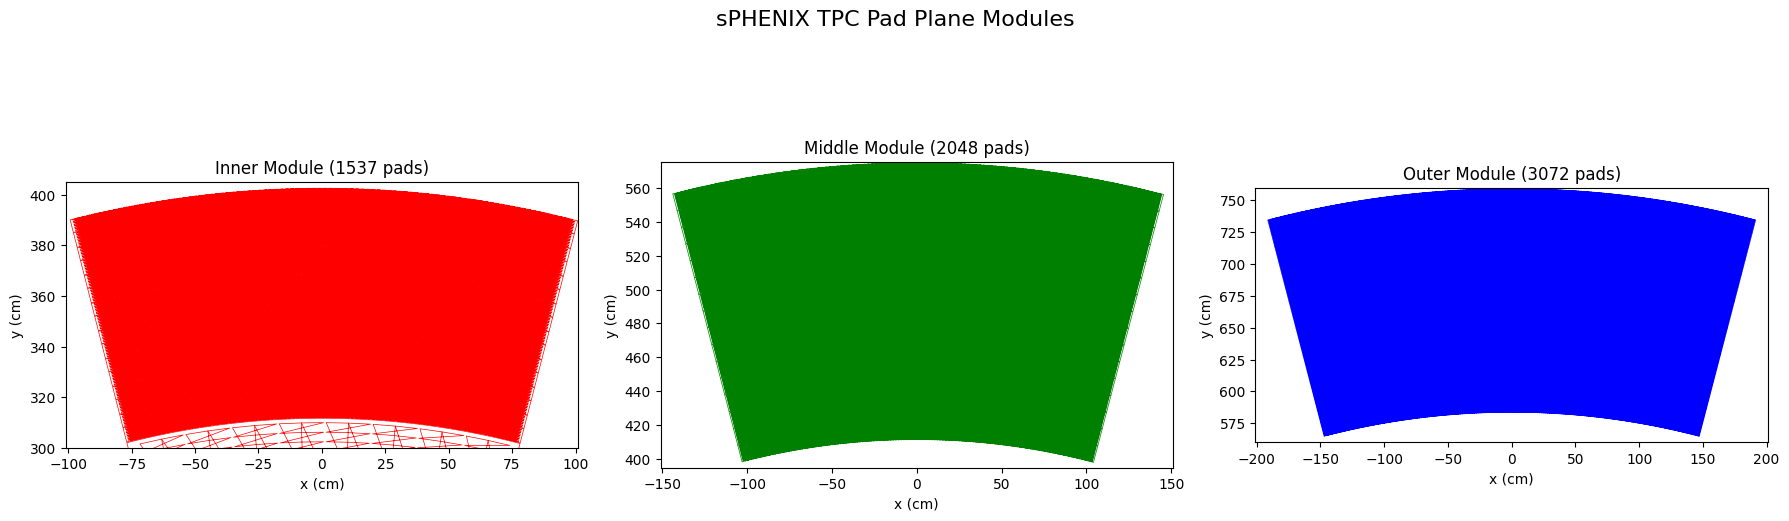


═══ Analysis Complete ═══


In [994]:
if __name__ == "__main__":
    print("═══ Complete TPC Single Electron Response ═══\n")
    brd_maps = [
        '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R1-RevA.brd',
        '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R2-RevA-Pads.brd',
        '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R3-RevA.brd',
    ]
    sch_maps = ['/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R1-RevA.sch',
    '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R2-RevA-Pads.sch',
    '/Users/chenxi/developer/sphenix/tpc_sim/TPC_Toy_Model/PadPlane/AutoPad-R3-RevA.sch',]
    # Update paths as needed
    print("Loading pad planes...")
    print("(Update file paths in brd_maps if needed)\n")
    
    try:
        # Load pad planes
        df_centroids = load_pad_planes(brd_maps)
        
        # 1. Visualize pad modules
        print("1. Visualizing pad plane modules...")
        fig_modules = visualize_pad_plane_modules(df_centroids)
        
        # 2. Test positions in each module
        test_positions = [
            (35.0, 10.0, 50.0),   # Inner module
            (30.0, 20.0, 100.0),  # Middle module  
            (45.0, 30.0, 75.0),   # Outer module
        ]
        
        for x0_cm, y0_cm, z0_cm in test_positions:
            print(f"\nTesting point ({x0_cm}, {y0_cm}, {z0_cm}) cm…")

            # convert to mm
            x0_mm = x0_cm*10
            y0_mm = y0_cm*10
            z0_mm = z0_cm*10

            # rotate into sector 0
            x_rot, y_rot, z_rot, sector, side = rotate_point_to_sector(x0_mm, y0_mm, z0_mm)
            print(f" → rotated into sector {sector}, side {side}")
            '''
            module, layer = which_layer(np.hypot(x_rot, y_rot))
            print(f" → that lands in module {module}, layer {layer}")

            # mark it on the pad‐plane plot
            ax = fig_modules.axes[module]
            ax.scatter([x_rot],[y_rot],
                    marker='X', s=200, c='k',
                    label=f"hit in sect {sector}")
            ax.legend(loc="upper right")
            plt.pause(0.1)

            
            
            serf, params, components = build_serf_zigzag_in_sector(
                x0_cm, y0_cm, z0_cm, df_centroids, return_components=True
            )

            # now you can plot it...
            fig = visualize_complete_response_zigzag(
                params['x0_cm'], params['y0_cm'], z0_cm, df_centroids
            )

            # …and gather some MC statistics
            n_mc = 20
            hits = []
            for _ in range(n_mc):
                wf = digitize_serf(serf, gain=polya_gain(), add_noise=True)
                hits.append(len(wf))
            print(f"   → pads above threshold: {np.mean(hits):.1f} ± {np.std(hits):.1f}")
            '''
        
        plt.show()
        
    except FileNotFoundError as e:
        print(f"\nError: Could not find pad plane files.")
        print(f"Please update the paths in brd_maps to point to your AutoPad files.")
        print(f"Current paths:")
        for path in brd_maps:
            print(f"  - {path}")
        print(f"\nError details: {e}")
    
    print("\n═══ Analysis Complete ═══")